# Twiter Sentiment Analysis
![Twitter Sentiment Analysis](https://miro.medium.com/max/644/1*OAR9kjMonh8rZJj0en9evQ.png)

**Sentiment Analysis** also known as “Opinion Mining”, Sentiment Analysis refers to the use of Natural Language Processing to determine the attitude, opinions and emotions of a speaker, writer, or other subject.

> It is the process of determining whether a piece of text or sentence is positive or negative. This is also called the *Polarity of the content*.

**Problem Statement**

A sentiment analysis job about the problems of each major U.S. airline and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

**DataSet**

This data originally came from [Crowdflower's Data for Everyone library.](http://www.crowdflower.com/data-for-everyone)
Data contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines:

1. American
2. Delta
3. SouthWest
4. United
5. US Airways
6. Virgin America

In [1]:
# Importing Libraries 

from fastai.metrics import accuracy
from fastai.text import *
from fastai import *
import gc
import os
import pandas as pd
import numpy as np

We will be using UMLFiT model implemented in fast.Ai for our task.

**What is ULMFiT ?**

> **ULMFiT** is essentially a method to enable transfer learning for any NLP task and achieve great results. All this, without having to train models from scratch. 

For more in details, please refer [ULMFiT Paper](https://arxiv.org/abs/1801.06146)

In [2]:
tweets = pd.read_csv('../input/twitter-airline-sentiment/Tweets.csv')
print('Shape: ', tweets.shape)
tweets.head()

Shape:  (14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = (df.isnull().sum())/(df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [4]:
check_missing_data(tweets)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
Total,0,0,0,5462,4118,0,14600,0,14608,0,0,13621,0,4733,4820
Percent,0,0,0,0.00373087,0.00281284,0,0.00997268,0,0.00997814,0,0,0.00930396,0,0.00323292,0.00329235
Types,int64,object,float64,object,float64,object,object,object,object,int64,object,object,object,object,object


In [5]:
# droping 3 columns which are 90% empty

tweets = tweets.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord'])

### Data Visualization

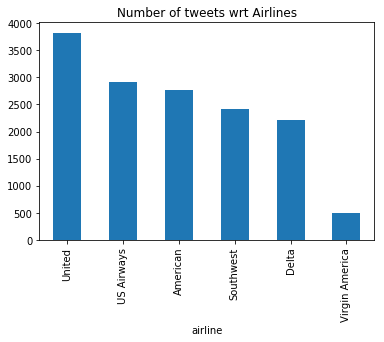

In [6]:
tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False).plot(kind='bar')
plt.title('Number of tweets wrt Airlines')
plt.show()

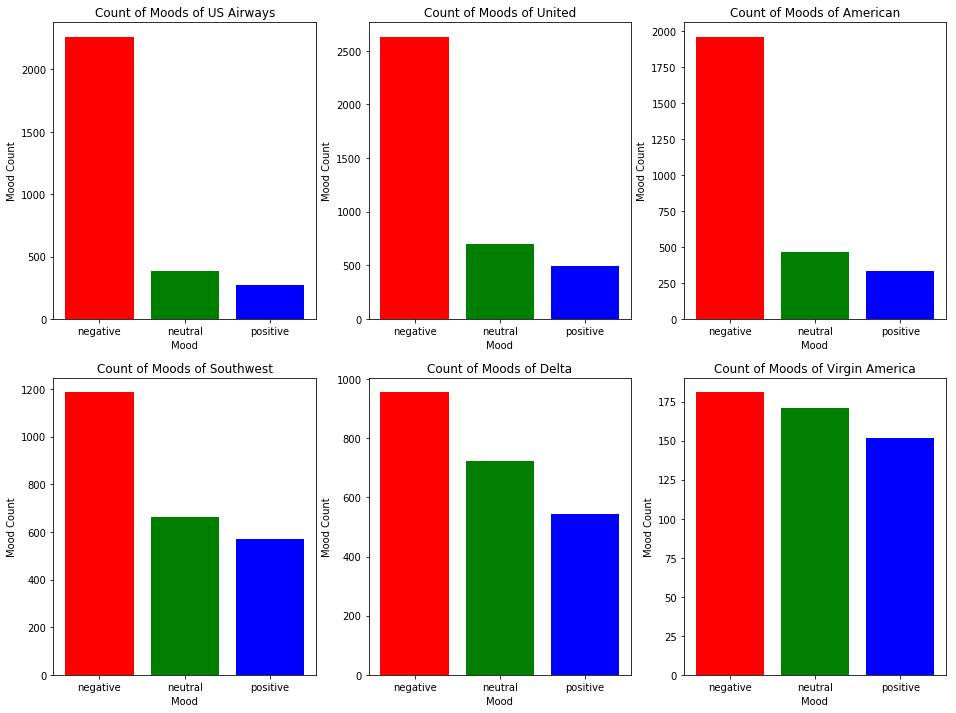

In [7]:
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

plt.figure(1,figsize=(16, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=tweets[tweets['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

***Wordclouds*** of the **Positive**, **Negative**, **Neutral** - airline_sentiment

In [8]:
from wordcloud import WordCloud,STOPWORDS

def generate_wordcloud(text, title): 
    wordcloud = WordCloud(relative_scaling = 1.0,stopwords = STOPWORDS, background_color='black').generate(text)
    fig,ax = plt.subplots(1,1,figsize=(14,18))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.margins(x=0, y=0)
    plt.title(title)
    plt.show()

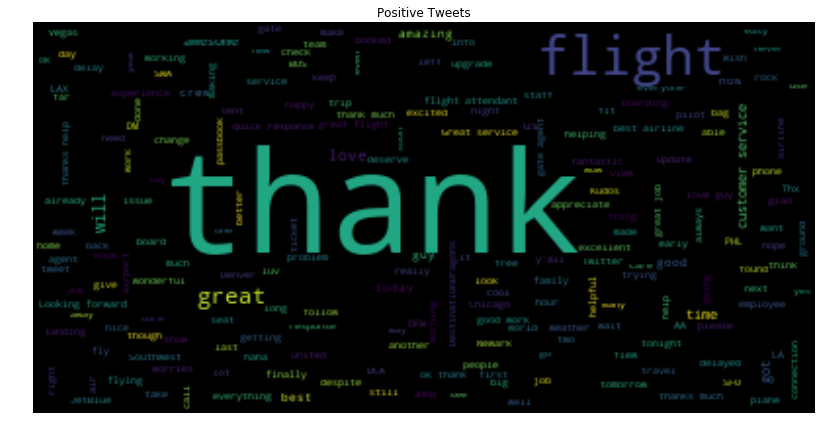

In [9]:
words_positive = ' '.join(tweets[tweets['airline_sentiment']=='positive']['text'])
cleaned_word_positive = " ".join([word for word in words_positive.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

generate_wordcloud(cleaned_word_positive, 'Positive Tweets')

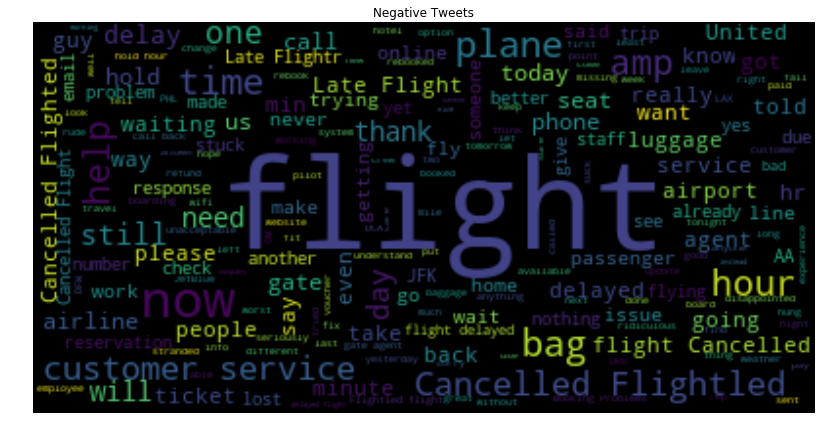

In [10]:
words_negative = ' '.join(tweets[tweets['airline_sentiment']=='negative']['text'])
cleaned_word_negative = " ".join([word for word in words_negative.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

generate_wordcloud(cleaned_word_negative, 'Negative Tweets')

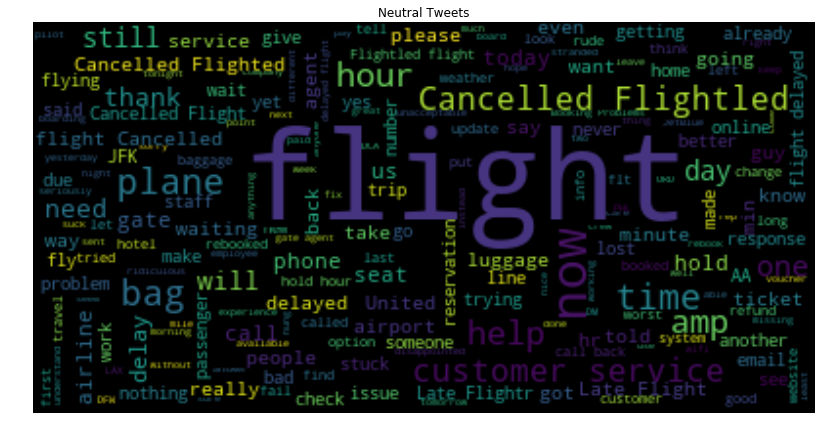

In [11]:
words_neutral = ' '.join(tweets[tweets['airline_sentiment']=='neutral']['text'])
cleaned_word_neutral = " ".join([word for word in words_neutral.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

generate_wordcloud(cleaned_word_negative, 'Neutral Tweets')

### Data Cleansing 

In [12]:
import re
import nltk
from nltk.corpus import stopwords

def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

tweets['clean_tweet']=tweets['text'].apply(lambda x: tweet_to_words(x))
tweets['Tweet_length']=tweets['text'].apply(lambda x: clean_tweet_length(x))
tweets['sentiment']=tweets['airline_sentiment'].apply(lambda x: 0 if x=='negative' else 1)

In [13]:
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# split data into training and validation set
df_trn, df_val = train_test_split(tweets, stratify = tweets['airline_sentiment'], test_size = 0.4, random_state = 678)

### ULMFiT Model

In [14]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

In [15]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.4)

In [16]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.819957,3.619319,0.439955,00:26


In [17]:
# unfreeze the learner object and train
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-2, 1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,3.258975,0.585240,0.811905,00:35
1,1.885191,0.486544,0.812351,00:36
2,1.384706,0.493445,0.812723,00:36
3,1.140052,0.470210,0.812500,00:36
4,0.986348,0.472810,0.812500,00:36


In [18]:
learn.save_encoder('ft_enc')

<center><h3> **Accuracy is >80%** </h3></center>